In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from regression_module import viz_roc

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
df = pd.read_csv('data/final_df.csv')
df = df.iloc[:,1:]
y = df.churn
X = df.drop('churn', axis = 1)

In [151]:
mm = MinMaxScaler()
df2 = pd.DataFrame(mm.fit_transform(X), columns = X.columns)
df2.head()

,seniorcitizen,tenure,monthlycharges,totalcharges,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,...,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0.0,0.013889,0.115423,0.003437,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.472222,0.385075,0.217564,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.027778,0.354229,0.012453,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.625000,0.239303,0.211951,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.027778,0.521891,0.017462,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 33)

# **1) Bagged Trees**

In [153]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier('gini', max_depth = 5), n_estimators = 20)
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [154]:
bagged_tree.score(X_train, y_train)

0.8097311624384703

In [155]:
bagged_tree.score(X_test, y_test)

0.7938671209540034

## Bagged Trees 2 - W/ GridSearchCV

In [156]:
dt = DecisionTreeClassifier(
                            criterion = 'entropy',
                            max_depth = 6,
                            min_samples_leaf = 1,
                            min_samples_split = 30,
                            random_state = 33)

bc_param_grid = {
    'bootstrap':[True, False],
    'bootstrap_features':[True, False],
    'n_estimators':[1,5,10,15,20,25],
    'max_samples':[0.2,0.4,0.6,0.8,1.0]
}

grid_search = GridSearchCV(BaggingClassifier(dt), param_grid = bc_param_grid, cv = 4, verbose = True)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   58.5s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                               criterion='entropy',
                                                                               max_depth=6,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                               min_samples_split=30,
                                                  

In [157]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.2, 'n_estimators': 25}
Best Score: 0.8068913290420295


In [158]:
test_preds = grid_search.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

In [159]:
print(f"Precision Score: {precision_score(y_test, test_preds)}")
print(f"Recall Score: {recall_score(y_test, test_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds)}")
print(f"F1 Score: {f1_score(y_test, test_preds)}")

Precision Score: 0.664804469273743
Recall Score: 0.49583333333333335
Accuracy Score: 0.794434980124929
F1 Score: 0.5680190930787591


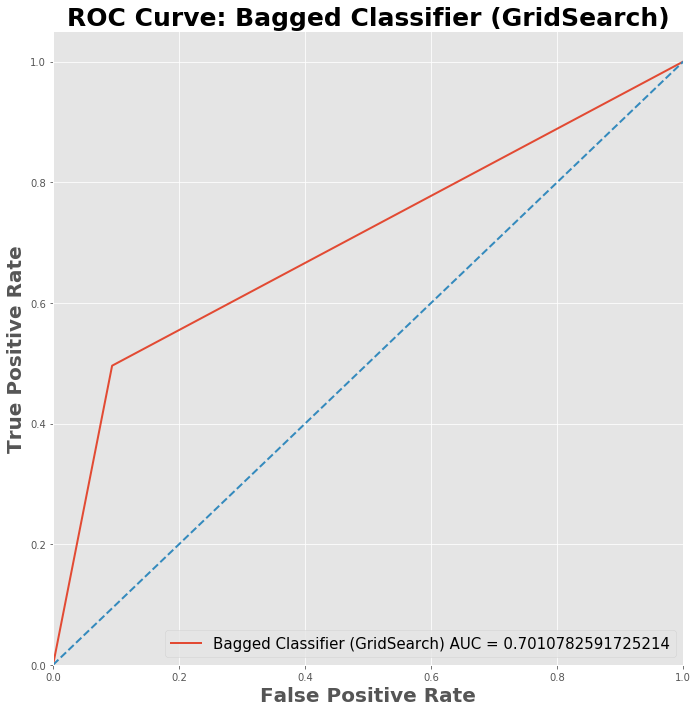

In [161]:
viz_roc(fpr, tpr, roc_auc, 'Bagged Classifier (GridSearch)')

In [162]:
pd.crosstab(y_test, test_preds, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,1161,120,1281
1,242,238,480
All,1403,358,1761


In [163]:
report1 = pd.DataFrame(classification_report(y_test, test_preds, output_dict = True)).transpose()
report1

,precision,recall,f1-score,support
0,0.827512,0.906323,0.865127,1281.000000
1,0.664804,0.495833,0.568019,480.000000
accuracy,0.794435,0.794435,0.794435,0.794435
macro avg,0.746158,0.701078,0.716573,1761.000000
weighted avg,0.783163,0.794435,0.784143,1761.000000


# **3) Random Forest - Vanilla**

# RF1

In [238]:
rf = RandomForestClassifier(random_state = 33)
rf.fit(X_train, y_train)
test_preds = rf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

In [239]:
print(f"Precision Score: {precision_score(y_test, test_preds)}")
print(f"Recall Score: {recall_score(y_test, test_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds)}")
print(f"F1 Score: {f1_score(y_test, test_preds)}")

Precision Score: 0.6494252873563219
Recall Score: 0.4708333333333333
Accuracy Score: 0.7864849517319704
F1 Score: 0.5458937198067633


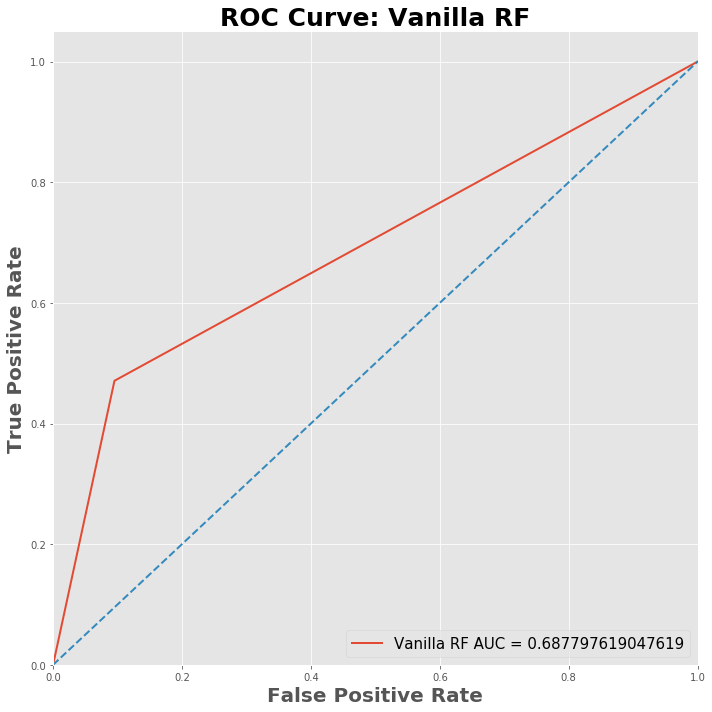

In [240]:
viz_roc(fpr, tpr, roc_auc, 'Vanilla RF')

In [241]:
pd.crosstab(y_test, test_preds, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,1159,122,1281
1,254,226,480
All,1413,348,1761


In [242]:
report2 = pd.DataFrame(classification_report(y_test, test_preds, output_dict = True)).transpose()
report2

,precision,recall,f1-score,support
0,0.820241,0.904762,0.860431,1281.000000
1,0.649425,0.470833,0.545894,480.000000
accuracy,0.786485,0.786485,0.786485,0.786485
macro avg,0.734833,0.687798,0.703162,1761.000000
weighted avg,0.773681,0.786485,0.774697,1761.000000


# **4) Random Forest - GridSearchCV**

In [245]:
param_grid = {
            'n_estimators': [20,22,25],
            'max_features': ['auto'],
            'max_depth': [8,10,12],
            'min_samples_split' : [20,25,30],
            'min_samples_leaf' : [1, 2, 3],
            'bootstrap':[True]
}

In [246]:
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv = 4, verbose = True)
gs_rf.fit(X_train, y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   26.8s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [247]:
test_preds = gs_rf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

In [248]:
gs_rf.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'n_estimators': 25}

In [249]:
gs_rf.best_score_

0.8084059068534646

In [250]:
print(f"Precision Score: {precision_score(y_test, test_preds)}")
print(f"Recall Score: {recall_score(y_test, test_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds)}")
print(f"F1 Score: {f1_score(y_test, test_preds)}")

Precision Score: 0.6528925619834711
Recall Score: 0.49375
Accuracy Score: 0.7904599659284497
F1 Score: 0.5622775800711743


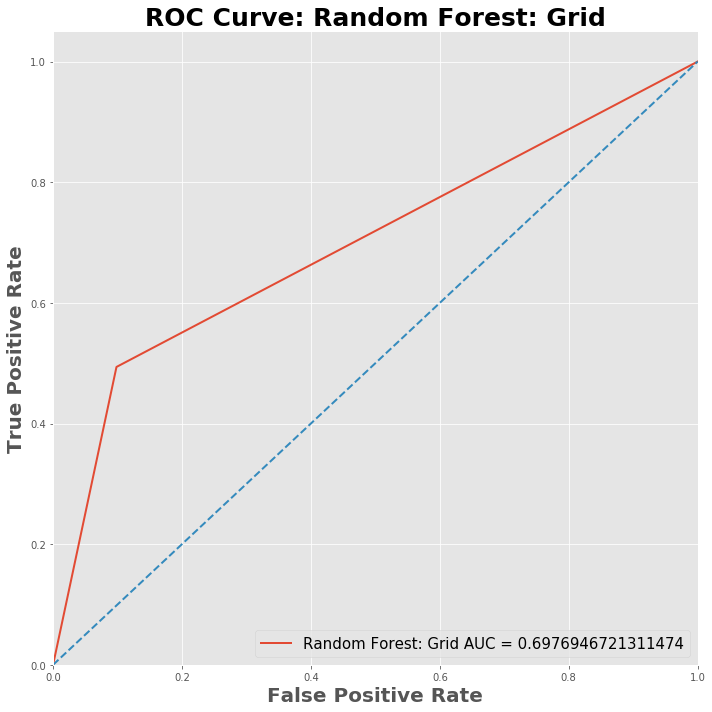

In [251]:
viz_roc(fpr, tpr, roc_auc, 'Random Forest: Grid')

In [252]:
pd.crosstab(y_test, test_preds, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,1155,126,1281
1,243,237,480
All,1398,363,1761


In [253]:
report3 = pd.DataFrame(classification_report(y_test, test_preds, output_dict = True)).transpose()
report3

,precision,recall,f1-score,support
0,0.826180,0.901639,0.862262,1281.00000
1,0.652893,0.493750,0.562278,480.00000
accuracy,0.790460,0.790460,0.790460,0.79046
macro avg,0.739536,0.697695,0.712270,1761.00000
weighted avg,0.778947,0.790460,0.780495,1761.00000


In [254]:
report1, report2, report3

(              precision    recall  f1-score      support
 0              0.827512  0.906323  0.865127  1281.000000
 1              0.664804  0.495833  0.568019   480.000000
 accuracy       0.794435  0.794435  0.794435     0.794435
 macro avg      0.746158  0.701078  0.716573  1761.000000
 weighted avg   0.783163  0.794435  0.784143  1761.000000,
               precision    recall  f1-score      support
 0              0.820241  0.904762  0.860431  1281.000000
 1              0.649425  0.470833  0.545894   480.000000
 accuracy       0.786485  0.786485  0.786485     0.786485
 macro avg      0.734833  0.687798  0.703162  1761.000000
 weighted avg   0.773681  0.786485  0.774697  1761.000000,
               precision    recall  f1-score     support
 0              0.826180  0.901639  0.862262  1281.00000
 1              0.652893  0.493750  0.562278   480.00000
 accuracy       0.790460  0.790460  0.790460     0.79046
 macro avg      0.739536  0.697695  0.712270  1761.00000
 weighted avg   0